# Spotify Genre Segmentation

- author: Virginia Ordoño Bernier
- date: April 2024

Cada persona tiene un gusto diferente en la música. No podemos identificar qué tipo de música le gusta a una persona simplemente conociendo su estilo de vida, pasatiempos o profesión. Por lo tanto, es difícil que las aplicaciones de transmisión de música recomienden música a una persona. Pero si sabemos qué tipo de canciones escucha una persona a diario, podemos encontrar similitudes en todos los archivos de música y recomendar música similar a la persona.

Ahí es donde entra en juego el análisis de conglomerados de géneros musicales. [Aquí](https://www.kaggle.com/datasets/iamsumat/spotify-top-2000s-mega-dataset/download) se os proporciona un conjunto de datos de canciones populares en Spotify, que contiene artistas y nombres de música con todas las características de audio de cada música. Su objetivo es agrupar géneros musicales en función de las similitudes en sus características de audio.

## 1. Carga de datos

In [24]:
import sys
sys.path.append('./')
from my_utils import *

import pandas as pd  # type: ignore

data_csv = '../data/spotify-2000.csv'
df = pd.read_csv(data_csv)
df.columns = df.columns.str.replace(' ', '_').str.lower()

df.rename(columns={'beats_per_minute_(bpm)': 'bpm', 'loudness_(db)': 'loudness', 'length_(duration)': 'duration', 'top_genre': 'genre'}, inplace=True)
df.drop('index', axis=1, inplace=True)
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
title,Sunrise,Black Night,Clint Eastwood,The Pretender,Waitin' On A Sunny Day,The Road Ahead (Miles Of The Unknown),She Will Be Loved,Knights of Cydonia,Mr. Brightside,Without Me
artist,Norah Jones,Deep Purple,Gorillaz,Foo Fighters,Bruce Springsteen,City To City,Maroon 5,Muse,The Killers,Eminem
genre,adult standards,album rock,alternative hip hop,alternative metal,classic rock,alternative pop rock,pop,modern rock,modern rock,detroit hip hop
year,2004,2000,2001,2007,2002,2004,2002,2006,2004,2002
bpm,157,135,168,173,106,99,102,137,148,112
energy,30,79,69,96,82,46,71,96,92,67
danceability,53,50,66,43,58,54,71,37,36,91
loudness,-14,-11,-9,-4,-5,-9,-6,-5,-4,-3
liveness,11,17,7,3,10,14,13,12,10,24
valence,68,81,52,37,87,14,54,21,23,66


## 2. Análisis Exploratorio de Datos

In [25]:
df.shape

(1994, 14)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1994 non-null   object
 1   artist        1994 non-null   object
 2   genre         1994 non-null   object
 3   year          1994 non-null   int64 
 4   bpm           1994 non-null   int64 
 5   energy        1994 non-null   int64 
 6   danceability  1994 non-null   int64 
 7   loudness      1994 non-null   int64 
 8   liveness      1994 non-null   int64 
 9   valence       1994 non-null   int64 
 10  duration      1994 non-null   object
 11  acousticness  1994 non-null   int64 
 12  speechiness   1994 non-null   int64 
 13  popularity    1994 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 218.2+ KB


In [27]:
ma = df.popularity.unique().max()
mi = df.popularity.unique().min()

print(f'min: {mi}, max: {ma}')

min: 11, max: 100


In [28]:
df.popularity.unique()

array([ 71,  39,  69,  76,  59,  45,  74,  77,  82,  49,  34,  26,  66,
        48,  57,  46,  81,  67,  55,  16,  50,  56,  84,  63,  72,  44,
        75,  40,  42,  53,  78,  65,  43,  51,  52,  38,  32,  47,  70,
        64,  73,  58,  30,  19,  41,  62,  83,  54,  80,  68,  36,  60,
        35,  61,  79,  33,  37,  27,  14,  28,  18,  29,  31,  85,  86,
        15,  20,  21,  13,  24,  87,  88,  25,  23,  17,  12,  95,  98,
       100,  22,  11], dtype=int64)

### 2.1. Explicación de las propiedades

- Title (Título): El nombre de la canción. Un valor por muestra.
- Artist (Artista): El nombre del artista o banda que interpretó la canción.
- Top Genre (Género Principal): El género principal de la canción, categorizado según su estilo musical predominante. 129 variedades.
- Year (Año): El año en el que se lanzó la canción.min: 1956, max: 2019
- bpm. pulsos por minuto. 145 variedades. min: 37, max: 206. Int.
- Energy (Energía): La intensidad y actividad percibida de la canción. Valores más altos indican canciones más enérgicas.98 variedaes. min: 3, max: 100. Int.
- Danceability (Bailable): Una medida de cuán adecuada es una canción para bailar, basada en elementos musicales como el ritmo y la estabilidad temporal. 84 tipos. min: 10, max: 96 Int.
- Loudness (DB) (Volumen en decibeles): El volumen promedio de la canción en decibeles (dB). Valores más negativos indican canciones más silenciosas.23 tipos. min: -27, max: -2. Int.
- Liveness (En Vivo): Una medida de la probabilidad de que la canción haya sido grabada en vivo. Valores más altos indican una mayor probabilidad de grabación en vivo. 94 tipos. min: 2, max: 99.
- Valence (Valencia): La positividad o negatividad percibida de una canción. Valores más altos indican canciones más positivas y felices. 97 tipos. min: 3, max: 99.
- Duration (Duración): 350 tipo. min: 1,121, max: 966. Es object.
- Acousticness (Acústico): Una medida de cuán acústica es la canción. Valores cercanos a 1 indican canciones más acústicas, mientras que valores cercanos a 0 indican canciones menos acústicas (más electrónicas).hay un pico pronunciado en los valores más bajos, indicando que muchas canciones no son acústicas.100 tipos. min: 0, max: 99.
- Speechiness (Hablado): Una medida de cuánta presencia de palabras habladas hay en la canción. Valores más altos indican canciones con más elementos hablados. 37 valores .min: 2, max: 55.
- Popularity (Popularidad): La popularidad de la canción, generalmente medida en una escala de 0 a 100, donde valores más altos indican mayor popularidad.81 valores. min: 11, max: 100. Int.

### 2.2. Gestión columna 'duration'. Es string y tiene valores con ,

In [29]:
# Suponemos que los valores con ',' son segundo igual. Por eso sustituimos por '' y convertimos a int
df['duration'] = df['duration'].str.replace(',', '').astype(int)

### 2.3. Gestión de duplicados

In [30]:
if df.duplicated().any():
    duplicated_rows = df[df.duplicated(keep=False)]  # keep=False para marcar todas las filas duplicadas
    print(duplicated_rows)

### 2.4.  Gestión de nulos

In [31]:
if (df.isna().sum() > 0).any():
    print(df.isna().sum()[df.isna().sum() > 0])

### 2.5. Visualización de los datos numéricos

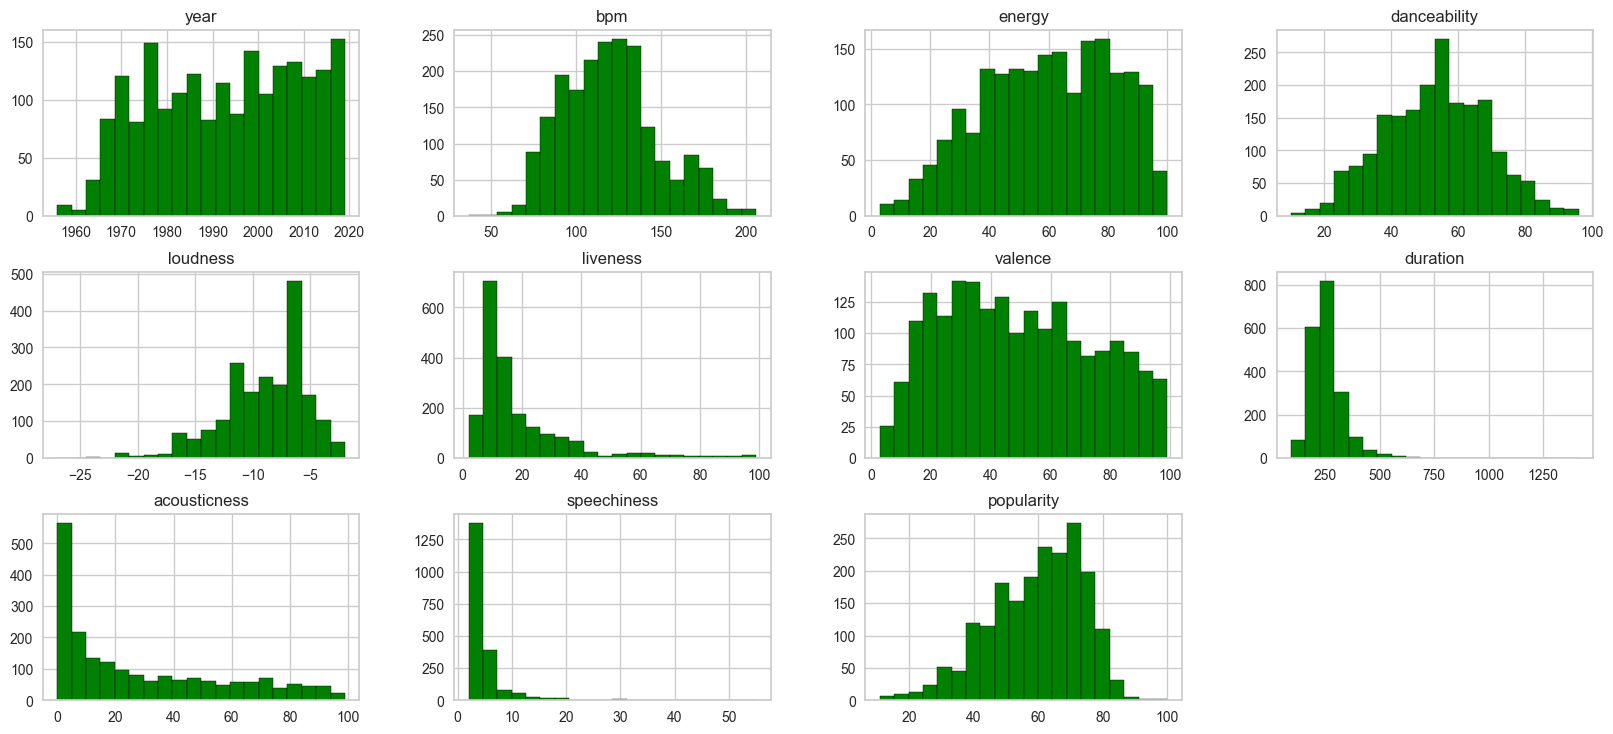

In [32]:
numeric_features = df.select_dtypes(exclude=['object'])
df[numeric_features.columns].hist(bins=20, figsize=(20, 15), layout=(5, 4), color='green', edgecolor='black');

### 2.6. Eliminación columnas: mejora un poco la precisión del modelo 

In [33]:
df.drop(['title', 'artist'], axis=1, inplace=True)

## 3. Configuración del modelo K-means

### 3.1. Preprocesamiento de los datos

In [34]:
import pandas as pd # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

### 3.2 Gráficos BIC y Elbow

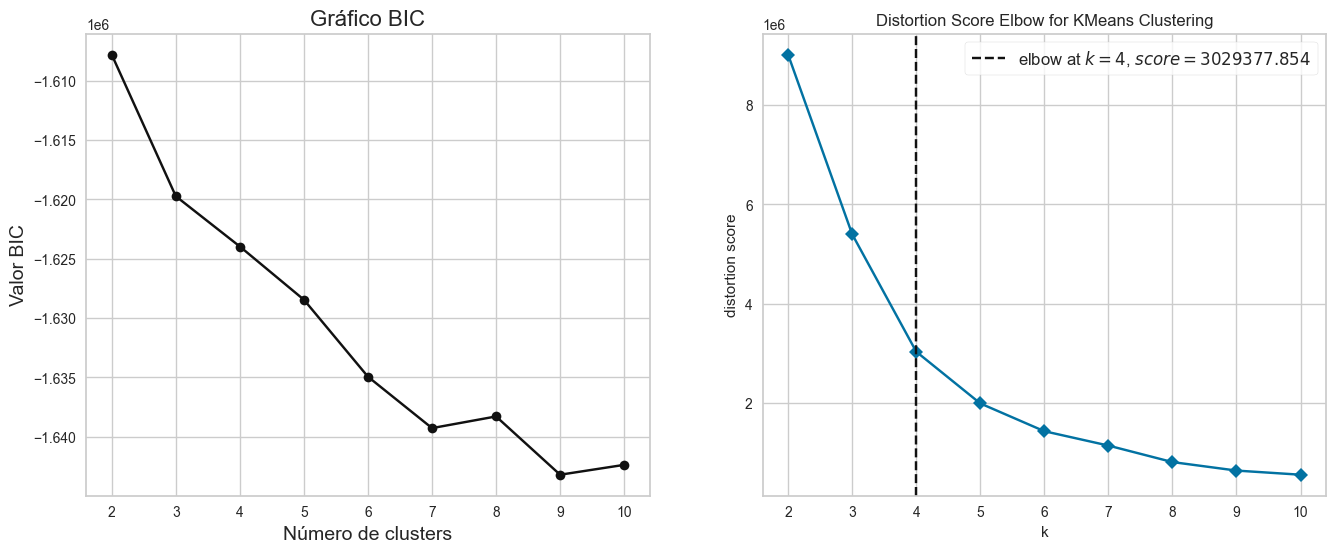

<Figure size 800x550 with 0 Axes>

Mejor k según BIC: 9
Mejor k según Elbow: 4


In [35]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from sklearn.cluster import KMeans # type: ignore
from yellowbrick.cluster import KElbowVisualizer # type: ignore

bic_array = []
K_MAX = 10
K_MIN = 2
N_INIT = 20
RANDOM_STATE= 42

for k in range(K_MIN, K_MAX+1):
    model_bic = KMeans(n_clusters=k, n_init=N_INIT, random_state=RANDOM_STATE)
    groups_bic = model_bic.fit_predict(df)
    bic_array.append(get_bic_values(k, groups_bic, df.values))
        
# Visualización de los resultados con BIC 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(K_MIN, K_MAX+1), bic_array, "ko-")
ax1.set_xticks(range(K_MIN, K_MAX+1))
ax1.set_title("Gráfico BIC", fontsize=16)
ax1.set_xlabel("Número de clusters", fontsize=14)
ax1.set_ylabel("Valor BIC", fontsize=14)

# Visualización de los resultados con Elbow Method
elbow_method = KElbowVisualizer(KMeans(random_state=RANDOM_STATE), k=K_MAX, timings=False)
elbow_method.fit(df)
elbow_method.show()

plt.tight_layout()
plt.show()

# Leyendas

# Obtiene el número óptimo de clusters según el método BIC
k_bic = np.argmin(bic_array) + K_MIN

# Obtiene el número óptimo de clusters según el método del codo
k_elbow = elbow_method.elbow_value_

print(f"Mejor k según BIC: {k_bic}")
print(f"Mejor k según Elbow: {k_elbow}")

## 4. Construcción del modelo K-means con los mejores hiperparámetros

In [36]:
model = KMeans(n_clusters=k_elbow, n_init=10, random_state=100, verbose=1)
groups = model.fit_predict(df)

Initialization complete
Iteration 0, inertia 4662924.674028442.
Iteration 1, inertia 4291777.877154309.
Iteration 2, inertia 4166473.2716296213.
Iteration 3, inertia 4066548.6833616956.
Iteration 4, inertia 3985904.388440714.
Iteration 5, inertia 3913879.483130092.
Iteration 6, inertia 3824611.915496379.
Iteration 7, inertia 3648845.6966120386.
Iteration 8, inertia 3552368.763300475.
Iteration 9, inertia 3510516.026403836.
Iteration 10, inertia 3460886.407716345.
Iteration 11, inertia 3407039.9630238414.
Iteration 12, inertia 3373152.813372545.
Iteration 13, inertia 3329509.9934637747.
Iteration 14, inertia 3304285.5335980267.
Iteration 15, inertia 3227333.683247941.
Iteration 16, inertia 3155318.5753466394.
Iteration 17, inertia 3085628.4355831617.
Iteration 18, inertia 3066498.406035819.
Iteration 19, inertia 3050347.8281678786.
Iteration 20, inertia 3039649.6026559556.
Iteration 21, inertia 3033311.5397705473.
Iteration 22, inertia 3030204.9376670504.
Iteration 23, inertia 3029377.8

### 4.1. Cálculo de la inertia y los centroides

In [37]:
print(f"\nInertia: {model.inertia_}\n")

centroids = model.cluster_centers_
df_centroids = pd.DataFrame(centroids, columns=df.columns[:model.cluster_centers_.shape[1]])
df_centroids['cluster'] = range(centroids.shape[0])  # Añade una columna 'cluster' con los índices de los centroides

# La columna 'cluster' es el índice del centroide
df_centroids = df_centroids.set_index('cluster')

print("Centroides:")
print("-"*15)
df_centroids.T


Inertia: 3029377.8541304683

Centroides:
---------------


cluster,0,1,2,3
year,-0.302590,1.789930e-02,-0.845207,4.280522e-02
bpm,0.062046,-1.056488e-02,0.112749,4.687668e-04
energy,0.016534,-2.674116e-02,-0.611977,3.646010e-02
danceability,-0.368559,9.083721e-02,-1.391953,-3.090876e-02
loudness,-0.200177,1.873601e-02,-1.094466,2.493484e-02
...,...,...,...,...
genre_stomp and holler,0.000000,9.803922e-04,0.000000,4.336809e-19
genre_streektaal,0.000000,2.168404e-19,0.000000,1.230012e-03
genre_trance,0.000000,9.803922e-04,0.000000,4.336809e-19
genre_uk pop,0.000000,9.803922e-04,0.000000,4.336809e-19


## 5. PCA

In [38]:
from sklearn.decomposition import PCA # type: ignore

pca = PCA(n_components=2)
features_pca = pca.fit_transform(df)

df_pca = pd.DataFrame(
    features_pca,
    columns=['pca1', 'pca2'])

# Añadir la columna 'cluster' al DataFrame
df_pca['cluster'] = groups

df_pca

,pca1,pca2,cluster
0,-61.447892,2.058521,1
1,-55.443237,-0.732876,1
2,78.554144,-1.756036,3
3,6.557871,-2.136769,3
4,-6.446917,-1.942739,3
...,...,...,...
1989,-134.448016,2.269893,1
1990,-126.445185,-0.414833,1
1991,-100.447870,-0.464832,1
1992,61.556227,1.876465,3


### 5.1. Visualización con PCA 

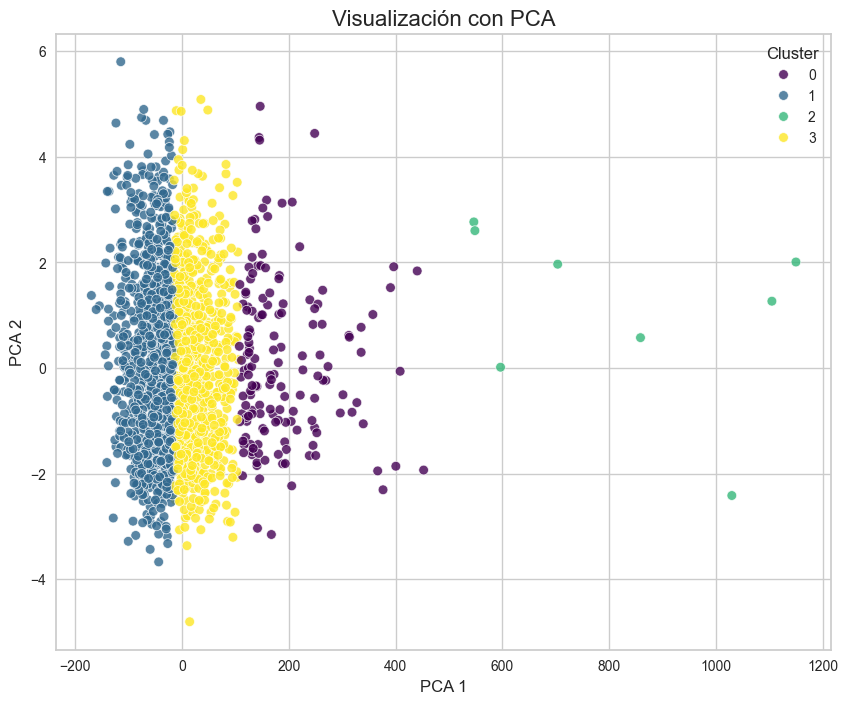

In [39]:
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# Graficar los puntos coloreados por cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue='cluster', palette='viridis', legend='full', alpha=0.8)

# Agregar título y etiquetas
plt.title('Visualización con PCA', fontsize=16)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()

## 6. Detección de outliers

In [40]:
# import numpy as np # type: ignore
# import pandas as pd # type: ignore
# import matplotlib.pyplot as plt # type: ignore
# from sklearn.cluster import KMeans # type: ignore

# N_INIT = 10 
# RANDOM_STATE = 100  
# N = df.shape[0] # Calcular el número de filas en el DataFrame
# K = groups.max() + 1  # Se suma 1 porque los índices de los clusters empiezan en 0

# # Calcular SSE excluyendo cada observación
# SSE = []
# for excluded in range(N):
#     # Eliminar la observación i
#     X_without_excluded = np.delete(df, excluded, axis=0)
    
#     # Aplicar K-medias a X_sin_i y obtener el índice SSE
#     model = KMeans(n_clusters=K, n_init=N_INIT, random_state=RANDOM_STATE).fit(X_without_excluded)
#     SSE.append(model.inertia_)

# # Detección visual de outliers
# plt.plot(np.arange(N), SSE, "ko-") #  generar los valores de x, donde N representa el número de observaciones en el conjunto de datos.
# plt.title("Índice SSE", fontsize=16)  
# plt.xlabel("Dato Excluido", fontsize=14)  
# plt.ylabel("SSE", fontsize=14)  
# plt.ylim(bottom=0)  # Límite inferior del eje y para asegurar que no se muestren valores negativos
# plt.show()

# # Detección analítica de outliers
# sigma = np.std(SSE)  # Calcular la desviación estándar de los valores SSE
# mu = np.mean(SSE)  # Calcular la media de los valores SSE
# umbral = 2  # Umbral para detectar outliers (2 para distribuciones normales)

# # Si la diferencia absoluta calculada es mayor que un múltiplo del umbral 
# # multiplicado por la desviación estándar (sigma) de los valores SSE, se considera que el índice i es un outlier.
# outliers = [i for i in range(N) if np.abs(SSE[i] - mu) > umbral * sigma] 

# # Crear DataFrame para mostrar los outliers
# outliers_df = pd.DataFrame({'Index': outliers, 'SSE': [SSE[idx] for idx in outliers]})
# outliers_df

## 7. Validación interna - Evaluación de los clústers generados

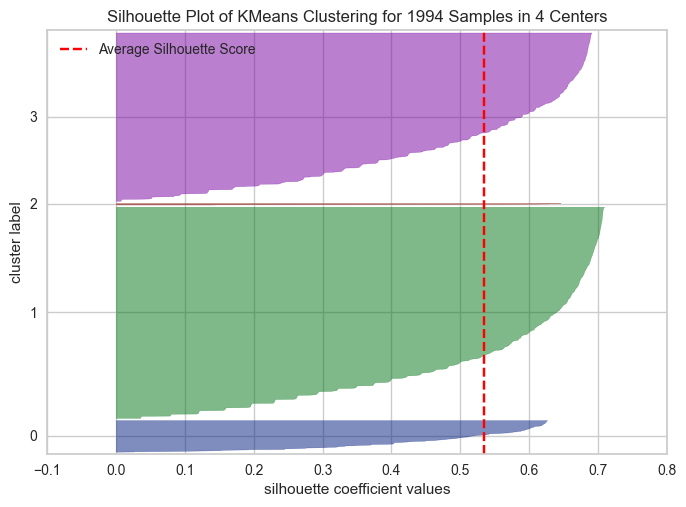

Silhouette Score: 0.534


In [41]:
from yellowbrick.cluster import SilhouetteVisualizer  # type: ignore
from sklearn.metrics import silhouette_score  # type: ignore
import warnings
warnings.filterwarnings("ignore")

visualizer = SilhouetteVisualizer(model, colors='sns_dark')
visualizer.fit(df)
visualizer.show()
plt.show()

print(f"Silhouette Score: {silhouette_score(df, groups):0.3}")

In [55]:
from yellowbrick.cluster import SilhouetteVisualizer  # type: ignore
from sklearn.metrics import silhouette_score  # type: ignore
from sklearn.cluster import KMeans

best_k = None
best_score = -1
results = []

# Suponiendo que df es tu DataFrame con los datos a clusterizar
for i in range(2, 60):
    model = KMeans(n_clusters=i, n_init=10, random_state=100, verbose=0)
    groups = model.fit_predict(df)
    
    # Calcular y mostrar el coeficiente de silueta
    score = silhouette_score(df, groups)
    print(f"Silhouette Score for n_clusters={i}: {score:0.3f}")
    
    # Guardar el mejor resultado
    if score > best_score:
        best_score = score
        best_k = i

# Imprimir el mejor resultado
print(f"\nMejor Silhouette Score: {best_score:0.3f} for n_clusters={best_k}")

Silhouette Score for n_clusters=2: 0.694
Silhouette Score for n_clusters=3: 0.621
Silhouette Score for n_clusters=4: 0.534
Silhouette Score for n_clusters=5: 0.527
Silhouette Score for n_clusters=6: 0.501
Silhouette Score for n_clusters=7: 0.509
Silhouette Score for n_clusters=8: 0.512
Silhouette Score for n_clusters=9: 0.506
Silhouette Score for n_clusters=10: 0.505
Silhouette Score for n_clusters=11: 0.489
Silhouette Score for n_clusters=12: 0.498
Silhouette Score for n_clusters=13: 0.493
Silhouette Score for n_clusters=14: 0.499
Silhouette Score for n_clusters=15: 0.491
Silhouette Score for n_clusters=16: 0.493
Silhouette Score for n_clusters=17: 0.470
Silhouette Score for n_clusters=18: 0.459
Silhouette Score for n_clusters=19: 0.460
Silhouette Score for n_clusters=20: 0.447
Silhouette Score for n_clusters=21: 0.437
Silhouette Score for n_clusters=22: 0.437
Silhouette Score for n_clusters=23: 0.432
Silhouette Score for n_clusters=24: 0.424
Silhouette Score for n_clusters=25: 0.424
